# Импортируем библиотеки и указываем устройство, на котором будет производиться обучение модели

In [1]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from modeling import RND, train_model
from utils import show_image_bbox
from dataset import NeurusCatnDogDataset

torch.manual_seed(141)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print("Device name", (torch.cuda.get_device_name() if (torch.cuda.is_available()) else "Cpu"))

Device name Tesla P100-PCIE-16GB


In [2]:
IMAGE_PATH = "../input/neurus-cats-n-dogs-test-task/"
jpg_paths = sorted([IMAGE_PATH + path for path in os.listdir(IMAGE_PATH) if path.endswith('jpg')])
txt_paths = sorted([IMAGE_PATH + path for path in os.listdir(IMAGE_PATH) if path.endswith('txt')])

# В тренировочном датасете будем использовать различные трансформации

In [3]:
train_transforms = A.Compose([
    A.Resize(width=256, height=256),
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='albumentations'))

val_transforms = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='albumentations'))

# Инициализируем датасет и разделяем на тренировочную и валидационную выборки

In [4]:
dataset = NeurusCatnDogDataset(jpg_paths, txt_paths, train_transforms)

val_length = len(dataset) // 5
train_length = len(dataset) - val_length
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_length, val_length])
val_dataset.transforms = val_transforms

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

# Так как конкретно эта задача обнаружения и локализации объектов очень узкая, в архитектуре модели и некоторых подходах можно сделать несколько допущений
- В основе архитектуры модели лежит предобученная ResNet50.
- Так как объект на картинке обязательно один и принадлежит одному из двух классов кот/собака (т.е. модель всегда должна классифицировать изображение как 0 или 1), для классификации используется выход из предпоследнего слоя модели Resnet через Fully-connected классификатор.
- Так как объект всегда один, вместо подходов RPN или Non-Maximum Suppression (которые подразумевают, что объектов может быть несколько) можно ограничиться только последовательностью нескольких сверточных слоев, которые затем будут обработаны Fully-connected регрессором в 4 относительных координаты через сигмоиду.
- Для того, чтобы учесть рецептивное поле нейронов и иметь возможность находить боксы по краям изображения, для локализации объекта будем применять сверточные слои к промежуточным выходам ResNet'a, а именно к выходу, имеющему 1024 канала и размер 14х14. 
- Модель получилась довольно тяжелая, возможно для такой задачи можно добиться схожих или более точных результатов при использовании более легких моделей и изменении положения и архитектуры локализующей подсети

In [5]:
model = RND()
model = model.to(device)

lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001) #weight_decay взят из оригинальной статьи про resnet
criterion = torch.nn.BCELoss() # У нас бинарная классификация, будем использовать кросс-энтропию
regression_criterion = torch.nn.SmoothL1Loss() 
# Используем этот лосс, т.к. большинство детекторов его используют c:
# Во время тестов модели было обнаружено, что при использовании не smoothL1, а его квадратного корня,
# mIoU на валидации за 30 эпох возрастает на 5%

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Тренируем модель

In [6]:
best_model, loss_history, iou_history = train_model(model, optimizer, train_dataloader, val_dataloader, criterion, regression_criterion, num_epochs=30)

Epoch 0/29. Loss: 0.3761. mIoU: 0.3097
Epoch 1/29. Loss: 0.1905. mIoU: 0.3292
Epoch 2/29. Loss: 0.1548. mIoU: 0.3813
Epoch 3/29. Loss: 0.1194. mIoU: 0.4991
Epoch 4/29. Loss: 0.0917. mIoU: 0.5415
Epoch 5/29. Loss: 0.0806. mIoU: 0.5625
Epoch 6/29. Loss: 0.0750. mIoU: 0.5750
Epoch 7/29. Loss: 0.0701. mIoU: 0.5920
Epoch 8/29. Loss: 0.0662. mIoU: 0.5947
Epoch 9/29. Loss: 0.0629. mIoU: 0.6100
Epoch 10/29. Loss: 0.0620. mIoU: 0.6235
Epoch 11/29. Loss: 0.0576. mIoU: 0.6320
Epoch 12/29. Loss: 0.0569. mIoU: 0.6399
Epoch 13/29. Loss: 0.0538. mIoU: 0.6347
Epoch 14/29. Loss: 0.0515. mIoU: 0.6401
Epoch 15/29. Loss: 0.0505. mIoU: 0.6509
Epoch 16/29. Loss: 0.0487. mIoU: 0.6496
Epoch 17/29. Loss: 0.0482. mIoU: 0.6618
Epoch 18/29. Loss: 0.0460. mIoU: 0.6633
Epoch 19/29. Loss: 0.0463. mIoU: 0.6725
Epoch 20/29. Loss: 0.0438. mIoU: 0.6767
Epoch 21/29. Loss: 0.0454. mIoU: 0.6798
Epoch 22/29. Loss: 0.0443. mIoU: 0.6798
Epoch 23/29. Loss: 0.0429. mIoU: 0.6899
Epoch 24/29. Loss: 0.0424. mIoU: 0.6809
Epoch 25/2

# Посмотрим на графики потерь на train'e и среднего IoU на валидации

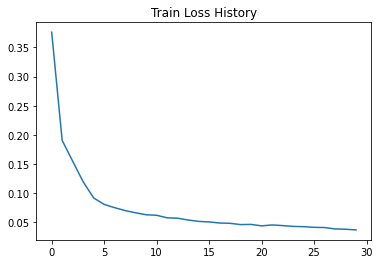

In [7]:
plt.plot(np.arange(0, len(loss_history)), loss_history)
plt.title('Train Loss History');

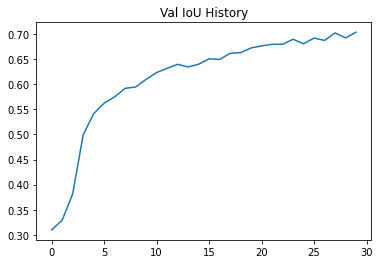

In [8]:
plt.plot(np.arange(0, len(iou_history)), iou_history)
plt.title('Val IoU History');

# Итоговые результаты оценки модели

- mIoU - 70.1%
- Accuracy классификации - 99.5%
- Время обработки одного батча (64 изображения) - 0.71 секунда
- Размер train выборки - 2708 изображений
- Размер валидационной выборки - 677 изображений

In [9]:
running_iou = 0.0
running_corrects = 0.0
since = time.time()

for inputs, labels in val_dataloader:
            
    inputs = inputs.to(device)
    target_bbox = labels[:, :4].to(device)
    target_class = labels[:, 4].to(device)
            
    with torch.no_grad():
        pred_class, pred_bbox = best_model(inputs)
        
        corrects = (pred_class.round().view(-1) == target_class).sum()
        running_corrects += corrects
        IoU = get_iou(pred_bbox, target_bbox, inputs)
        running_iou += IoU
        
epoch_time = time.time() - since
one_batch_time = epoch_time/len(val_dataloader)

mIoU = running_iou/len(val_dataloader) * 100
accuracy = running_corrects/len(val_dataset) * 100
print(f'mIoU {mIoU:.2f}%, classification accuracy {accuracy:.2f}%, {one_batch_time:.4f}s per batch, {len(train_dataset)} train, {len(val_dataset)} valid')

mIoU 70.10%, classification accuracy 99.56%, 0.7135s per batch, 2708 train, 677 valid


# Посмотрим на то, как модель отклассифицирует и локализует объекты из случайных 5 изображений валидационной выборки
- Зеленым цветом обозначен ground truth bbox
- Красным цветом обозначен bbox, предсказанный моделью

Между прочим, на первой картинке я даже больше согласен с предсказанием модели, чем с ground truth'ом :)

Class: dog


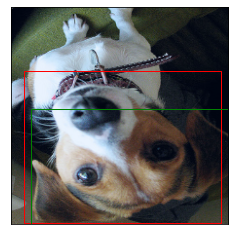

Class: cat


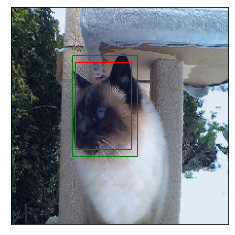

Class: cat


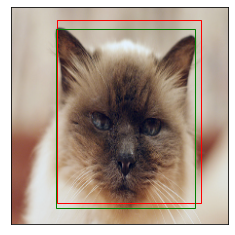

Class: dog


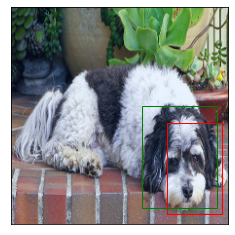

Class: dog


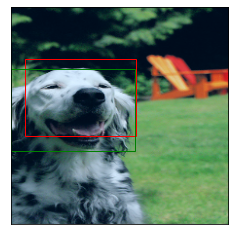

In [10]:
test_im, true_bbox = next(iter(val_dataloader))
    
with torch.no_grad():
    pred, bbox = model(test_im.to(device))
        

for i in range(5):
    print(f"Class: {'dog' if pred[i] > 0.5 else 'cat'}")
    show_image_bbox(test_im[i].permute(1, 2, 0), [bbox.cpu()[i], true_bbox[i]])